# Comparing kelp forest health
<br>

This file:
1) imports PACE OCI data from a kelp forest off of the Channel Islands
2) creates functions for QWIP analysis and to separate OCI data into three AVW types: blue, green, and brown
3) classifies kelp forest into three color groups
4) assesses percentage of color classes over a period of time
5) integrates coastal upwelling index (CUTI) to kelp forest health

## First we import kelp forest data from PACE
bbox defines kelp forest area: change if interested in different area

In [ ]:
# import packages we'll need
import earthaccess
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

# login to earthaccess
auth = earthaccess.login(persist=True)

# kelp forest bbox
# note: bounding boxes are for level 2 data
bbox = (-120.75, 33.5, -119, 34.5)

# access PACE OCI from this area
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L2_AOP',
    temporal = ("2025-03-09", "2025-03-09"), # okay cool found a day that doesn't suck
    bounding_box = bbox
)

fileset = earthaccess.open(results);

# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds = ds.unify_chunks()
ds.chunks


## Lets quickly check what this looks like with a plot
If you change the bbox above, adjust the image boundaries here

In [ ]:
rrs_da = ds["Rrs"]
avw_da = ds["avw"]
wavelengths = ds["wavelength_3d"]

# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# Get the figure set up, add a map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Put some lines in there so we know where we are
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop the image down a bit so we can focus on an area
ax.set_extent([-121, -118, 33, 35], crs=ccrs.PlateCarree())

# Plot and adjust colorbar limits, put "pad" argument in there to move the colorbar away from the image (otherwise it overlaps)
img = avw_da.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax, cbar_kwargs={"pad": 0.1})

## QWIP processing 
Thanks Ryan and James for this!

In [1]:
"""QWIP (quality water index polynomial) helpers and plots.

This module computes QWIP metrics from water-leaving reflectance spectra and
provides convenience plotting. The workflow is:

1. Subset to visible wavelengths (e.g., 400–700 nm).
2. Compute AVW (apparent visible wavelength) and integrated brightness.
3. Compute NDI(490,665) and a polynomial prediction vs AVW.
4. Classify spectra into 400A/500A/600A types and flag QWIP outliers.

Public API
----------
- :func:`calc_avw`
- :func:`calc_brightness`
- :func:`process_qwip_data`
- :func:`plot_qwip`
- :func:`plot_normalized_spectra`
- :func:`run_qwip_analysis`

"""

from __future__ import annotations

from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.integrate import trapezoid

__all__ = [
    "QwipResults",
    "calc_avw",
    "calc_brightness",
    "process_qwip_data",
    "plot_qwip",
    "plot_normalized_spectra",
    "run_qwip_analysis",
]


class QwipResults(TypedDict):
    """Container for QWIP outputs from :func:`process_qwip_data`."""

    avw: np.ndarray
    NDI: np.ndarray
    QWIP_Score: np.ndarray
    ind_400A: np.ndarray  # bool mask
    ind_500A: np.ndarray  # bool mask
    ind_600A: np.ndarray  # bool mask
    poly_coeffs: np.ndarray
    failed_indices: np.ndarray  # int idx array
    passed_indices: np.ndarray  # int idx array


def calc_avw(wavelengths: np.ndarray, rrs: np.ndarray) -> np.ndarray:
    """Calculate Apparent Visible Wavelength (AVW).

    AVW is defined here as::

        AVW = sum(Rrs) / sum(Rrs / lambda)

    Parameters
    ----------
    wavelengths
        1-D array of wavelengths (nm) of shape ``(n_wl,)``.
    rrs
        Water-leaving reflectance array of shape ``(n_samples, n_wl)`` or
        ``(n_wl,)``. If 1-D, it is treated as one sample.

    Returns
    -------
    numpy.ndarray
        AVW per sample, shape ``(n_samples,)``.

    Raises
    ------
    ValueError
        If the wavelengths length does not match the reflectance spectral axis.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.atleast_2d(np.asarray(rrs, dtype=float))
    if X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")

    num = np.sum(X, axis=1)
    with np.errstate(invalid="ignore", divide="ignore"):
        den = np.sum(X / wl, axis=1)
        avw = num / den
    return avw


def calc_brightness(wavelengths: np.ndarray, rrs: np.ndarray) -> np.ndarray:
    """Calculate integrated “brightness” using the trapezoidal rule.

    Parameters
    ----------
    wavelengths
        1-D array of wavelengths (nm) of shape ``(n_wl,)``.
    rrs
        Reflectance array of shape ``(n_samples, n_wl)`` or ``(n_wl,)``.

    Returns
    -------
    numpy.ndarray
        Integral per sample, shape ``(n_samples,)``.

    Raises
    ------
    ValueError
        If the wavelength length does not match the reflectance spectral axis.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.atleast_2d(np.asarray(rrs, dtype=float))
    if X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")
    return trapezoid(y=X, x=wl, axis=-1)


def process_qwip_data(
    wavelengths: np.ndarray,
    rrs: np.ndarray,
    avw: np.ndarray,
) -> QwipResults:
    """Compute QWIP masks and scores for spectra.

    Parameters
    ----------
    wavelengths
        1-D array of wavelengths (nm), shape ``(n_wl,)``.
    rrs
        Reflectance array of shape ``(n_samples, n_wl)``.
    avw
        Apparent Visible Wavelength per sample, shape ``(n_samples,)``.

    Returns
    -------
    QwipResults
        Typed mapping with AVW, NDI, QWIP_Score, type masks, and pass/fail indices.

    Notes
    -----
    - NDI is computed as ``(Rrs665 - Rrs490) / (Rrs665 + Rrs490)``.
    - The polynomial coefficients are fixed (Balasubramanian 2020 fit).
    - Fail criteria: type-range violations OR ``|QWIP_Score| > 0.2``.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.asarray(rrs, dtype=float)
    if X.ndim != 2:
        raise ValueError("rrs must be a 2-D array (n_samples, n_wl)")
    if X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")
    avw = np.asarray(avw, dtype=float).reshape(-1)
    if avw.shape[0] != X.shape[0]:
        raise ValueError("avw length must match number of spectra in rrs")

    # Find nearest indices to target wavelengths
    idx490 = int(np.argmin(np.abs(wl - 490.0)))
    idx560 = int(np.argmin(np.abs(wl - 560.0)))
    idx665 = int(np.argmin(np.abs(wl - 665.0)))

    # Normalized Difference Index (NDI)
    num = X[:, idx665] - X[:, idx490]
    den = X[:, idx665] + X[:, idx490]
    with np.errstate(invalid="ignore", divide="ignore"):
        ndi = num / den

    # Polynomial coefficients for NDI vs AVW
    p = np.array(
        [-8.399885e-09, 1.715532e-05, -1.301670e-02, 4.357838, -5.449532e02],
        dtype=float,
    )

    # Type masks (Balasubramanian 2020)
    step1 = X[:, idx665] > X[:, idx560]
    step2 = X[:, idx665] > 0.025
    step3 = X[:, idx560] < X[:, idx490]

    ind_600A = step1 | step2
    ind_500A = (~step1 & ~step2) & ~step3
    ind_400A = (~step1 & ~step2) & step3

    # QWIP score (difference from polynomial prediction)
    ndi_pred = np.polyval(p, avw)
    qwip_score = ndi - ndi_pred

    # --- Classification Logic ---

    # Fail flags
    failed_400 = ind_400A & ((avw < 410.0) | (avw > 520.0))
    failed_500 = ind_500A & ((avw < 490.0) | (avw > 590.0))
    failed_600 = ind_600A & ((avw < 550.0) | (avw > 600.0))
    type_failure = failed_400 | failed_500 | failed_600
    qwip_failure = (qwip_score < -0.2) | (qwip_score > 0.2)

    is_failed = type_failure | qwip_failure
    failed_indices = np.where(is_failed)[0]
    passed_indices = np.where(~is_failed)[0]

    return QwipResults(
        avw=avw,
        NDI=ndi,
        QWIP_Score=qwip_score,
        ind_400A=ind_400A,
        ind_500A=ind_500A,
        ind_600A=ind_600A,
        poly_coeffs=p,
        failed_indices=failed_indices,
        passed_indices=passed_indices,
    )


def plot_qwip(
    results: QwipResults,
    title: str = "QWIP Analysis",
    *,
    show: bool = True,
):
    """Generate a QWIP scatter with polynomial bands.

    Parameters
    ----------
    results
        Output from :func:`process_qwip_data`.
    title
        Plot title.
    show
        If ``True`` (default), call :func:`matplotlib.pyplot.show`. If ``False``,
        the caller is responsible for drawing/closing the figure.

    Returns
    -------
    (fig, ax)
        Matplotlib figure and axis.

    """
    avw = results["avw"]
    ndi = results["NDI"]
    ind_400A = results["ind_400A"]
    ind_500A = results["ind_500A"]
    ind_600A = results["ind_600A"]
    p = results["poly_coeffs"]

    avw_poly = np.arange(400.0, 631.0)
    fit1 = np.polyval(p, avw_poly)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(title, fontsize=18, fontweight="bold")

    # Classified points
    ax.plot(
        avw[ind_400A],
        ndi[ind_400A],
        "ok",
        markersize=5,
        markerfacecolor="b",
        label="Type I Blue-Green",
    )
    ax.plot(
        avw[ind_500A],
        ndi[ind_500A],
        "ok",
        markersize=5,
        markerfacecolor="g",
        label="Type II Green",
    )
    ax.plot(
        avw[ind_600A],
        ndi[ind_600A],
        "ok",
        markersize=5,
        markerfacecolor="r",
        label="Type III Brown",
    )

    # Polynomial & thresholds
    ax.plot(avw_poly, fit1, "-k", linewidth=2)
    ax.plot(avw_poly, fit1 + 0.1, "--g", linewidth=2)
    ax.plot(avw_poly, fit1 - 0.1, "--g", linewidth=2)
    ax.plot(avw_poly, fit1 + 0.2, "--", linewidth=2, color=(0.9290, 0.6940, 0.1250))
    ax.plot(avw_poly, fit1 - 0.2, "--", linewidth=2, color=(0.9290, 0.6940, 0.1250))
    ax.plot(avw_poly, fit1 + 0.3, "--", linewidth=2, color=(0.8500, 0.3250, 0.0980))
    ax.plot(avw_poly, fit1 - 0.3, "--", linewidth=2, color=(0.8500, 0.3250, 0.0980))
    ax.plot(avw_poly, fit1 + 0.4, "-r", linewidth=2)
    ax.plot(avw_poly, fit1 - 0.4, "-r", linewidth=2)

    # Labels and legends
    ax.set_xlabel("AVW (nm)", fontsize=16)
    ax.set_ylabel("NDI (490, 665)", fontsize=16)
    ax.set_ylim(-2.5, 2.0)
    ax.set_xlim(440, 600)
    ax.grid(True, linestyle=":", alpha=0.6)

    legend1 = ax.legend(loc="lower right", title="Data Types", fontsize=12)
    ax.add_artist(legend1)

    legend_lines = [
        Line2D([0], [0], color="g", lw=2, linestyle="--", label="QWIP ± 0.1"),
        Line2D(
            [0],
            [0],
            color=(0.9290, 0.6940, 0.1250),
            lw=2,
            linestyle="--",
            label="QWIP ± 0.2",
        ),
        Line2D(
            [0],
            [0],
            color=(0.8500, 0.3250, 0.0980),
            lw=2,
            linestyle="--",
            label="QWIP ± 0.3",
        ),
        Line2D([0], [0], color="r", lw=2, linestyle="-", label="QWIP ± 0.4"),
    ]
    ax.legend(handles=legend_lines, loc="upper left", title="Thresholds", fontsize=12)

    if show:
        plt.show()
    return fig, ax


def plot_normalized_spectra(
    results: QwipResults,
    wavelengths: np.ndarray,
    rrs: np.ndarray,
    brightness: np.ndarray,
    *,
    title_suffix: str = "",
    show: bool = True,
):
    """Plot brightness-normalized spectra for pass/fail sets, colored by AVW.

    Parameters
    ----------
    results
        Output from :func:`process_qwip_data`.
    wavelengths
        1-D wavelengths (nm), shape ``(n_wl,)``.
    rrs
        Reflectance array, shape ``(n_samples, n_wl)``.
    brightness
        Integrated brightness per sample, from :func:`calc_brightness`.
    title_suffix
        Appended to the figure title.
    show
        If ``True`` (default) call ``plt.show()``; otherwise just return fig/axes.

    Returns
    -------
    (fig, (ax1, ax2))
        Matplotlib figure and axes for passed/failed spectra.

    """
    wl = np.asarray(wavelengths, dtype=float).reshape(-1)
    X = np.asarray(rrs, dtype=float)
    if X.ndim != 2 or X.shape[1] != wl.shape[0]:
        raise ValueError("wavelengths length must match rrs second dimension")
    brightness_arr = np.asarray(brightness, dtype=float).reshape(-1)
    if brightness_arr.shape[0] != X.shape[0]:
        raise ValueError("brightness length must match number of spectra in rrs")

    with np.errstate(divide="ignore", invalid="ignore"):
        norm_rrs = X / brightness_arr[:, None]
    norm_rrs[~np.isfinite(norm_rrs)] = np.nan
    passed = results["passed_indices"]
    failed = results["failed_indices"]
    avw = results["avw"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    fig.suptitle(f"Normalized Spectra - {title_suffix}", fontsize=18, fontweight="bold")

    cmap = plt.get_cmap("jet")
    norm = plt.Normalize(vmin=440, vmax=600)

    # Passed
    ax1.set_title(f"Passed Spectra ({len(passed)})", fontsize=14)
    for i in passed:
        ax1.plot(wl, norm_rrs[i, :], color=cmap(norm(avw[i])), alpha=0.6)
    ax1.set_xlabel("Wavelength (nm)", fontsize=12)
    ax1.set_ylabel("Normalized Rrs (Rrs / Brightness)", fontsize=12)

### Prepare data for use in QWIP analysis
We are going to process the data in chunks and pre-subset wavelengths to the visible spectra to reduce memory load.

In [ ]:
import numpy as np
from tqdm import tqdm

LINES_PER_CHUNK = 32  # match OCI chunking

# wavelengths + visible subset
wavelengths = ds["wavelength_3d"].values.astype(float)
vis = (wavelengths >= 400) & (wavelengths <= 720) ## increased wv to 720
wavelengths_vis = wavelengths[vis]

n_lines = ds.sizes["number_of_lines"]
n_pixels = ds.sizes["pixels_per_line"]

# create arrays
all_lat = []
all_lon = []

all_avw = []
all_qwip = []

all_ind_400A = []
all_ind_500A = []
all_ind_600A = []

In [ ]:
# processing chunk - also filters QWIP to be +/- 0.1
for i0 in tqdm(range(0, n_lines, LINES_PER_CHUNK)):
    i1 = min(i0 + LINES_PER_CHUNK, n_lines)

    # --- slice chunk ---
    Rrs_chunk = (
        ds["Rrs"]
        .isel(number_of_lines=slice(i0, i1))
        .sel(wavelength_3d=wavelengths_vis)
    )

    lat_chunk = ds["latitude"].isel(number_of_lines=slice(i0, i1))
    lon_chunk = ds["longitude"].isel(number_of_lines=slice(i0, i1))

    # --- reshape to (n_samples, n_wl) ---
    Rrs_np = (
        Rrs_chunk
        .transpose("number_of_lines", "pixels_per_line", "wavelength_3d")
        .values
    )

    rrs = Rrs_np.reshape(-1, Rrs_np.shape[-1])

    # --- mask invalid reflectance ---
    rrs[rrs <= 0] = np.nan
    good = np.all(np.isfinite(rrs), axis=1)
    if not np.any(good):
        continue

    rrs = rrs[good]

    # --- QWIP ---
    avw = calc_avw(wavelengths_vis, rrs)
    results = process_qwip_data(wavelengths_vis, rrs, avw)

    # --- keep only QWIP ± 0.1 ---
    good_qwip = np.abs(results["QWIP_Score"]) <= 0.1
    if not np.any(good_qwip):
        continue

    # --- append results ---
    all_avw.append(results["avw"][good_qwip])
    all_qwip.append(results["QWIP_Score"][good_qwip])

    all_ind_400A.append(results["ind_400A"][good_qwip])
    all_ind_500A.append(results["ind_500A"][good_qwip])
    all_ind_600A.append(results["ind_600A"][good_qwip])

    lat_flat = lat_chunk.values.reshape(-1)[good][good_qwip]
    lon_flat = lon_chunk.values.reshape(-1)[good][good_qwip]

    all_lat.append(lat_flat)
    all_lon.append(lon_flat)

avw_all = np.concatenate(all_avw)
qwip_all = np.concatenate(all_qwip)

ind_400A_all = np.concatenate(all_ind_400A)
ind_500A_all = np.concatenate(all_ind_500A)
ind_600A_all = np.concatenate(all_ind_600A)

lat_all = np.concatenate(all_lat)
lon_all = np.concatenate(all_lon)

n = len(avw_all)

assert n == len(qwip_all)
assert n == len(ind_400A_all)
assert n == len(lat_all)
assert n == len(lon_all)

print("Total good QWIP spectra:", n)

## Now, we can plot what this looks like with our three types of AVW

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define figure and map projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and gridlines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray', alpha=0.5)
ax.set_extent([-121, -118, 33, 35], crs=ccrs.PlateCarree()) # zoom in on our box

# Scatter the QWIP points
ax.scatter(lon_all[ind_400A_all], lat_all[ind_400A_all],
           s=5, alpha=0.6, color="#1f77b4", label="Type I")  # blue
ax.scatter(lon_all[ind_500A_all], lat_all[ind_500A_all],
           s=5, alpha=0.6, color="#2ca02c", label="Type II")  # green
ax.scatter(lon_all[ind_600A_all], lat_all[ind_600A_all],
           s=5, alpha=0.6, color="#d62728", label="Type III")  # red/brown

# Add legend
ax.legend(title="QWIP Types", markerscale=3, fontsize=12, title_fontsize=13)

# Titles
ax.set_title("PACE OCI QWIP ±0.w (Chunked)", fontsize=16, fontweight="bold")

plt.show()


## Testing over time
Create function kelp_color_stats that returns the fraction of pixels of each color type

In [2]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import earthaccess
import xarray as xr

# login to earthaccess
auth = earthaccess.login(persist=True)

# define kelp box
kelp_bbox = {
    "lon_min": -120.75,
    "lon_max": -119,
    "lat_min": 33.5,
    "lat_max": 34.5,
}

In [3]:
def run_qwip_chunked(ds, tol=0.2, lines_per_chunk=32):
    """
    Run QWIP per chunk, return only good (±tol) Type I/II/III pixels + coords.
    """

    # --- wavelengths ---
    wavelengths = ds["wavelength_3d"].values.astype(float)
    vis = (wavelengths >= 400) & (wavelengths <= 720)
    wavelengths_vis = wavelengths[vis]

    n_lines = ds.sizes["number_of_lines"]

    # --- output containers ---
    all_lat, all_lon = [], []
    all_ind_400A, all_ind_500A, all_ind_600A = [], [], []

    # --- chunk loop ---
    for i0 in range(0, n_lines, lines_per_chunk):
        i1 = min(i0 + lines_per_chunk, n_lines)

        Rrs_chunk = (
            ds["Rrs"]
            .isel(number_of_lines=slice(i0, i1))
            .sel(wavelength_3d=wavelengths_vis)
        )

        lat_chunk = ds["latitude"].isel(number_of_lines=slice(i0, i1))
        lon_chunk = ds["longitude"].isel(number_of_lines=slice(i0, i1))

        # reshape → (n_samples, n_wl)
        Rrs_np = (
            Rrs_chunk
            .transpose("number_of_lines", "pixels_per_line", "wavelength_3d")
            .values
        )
        rrs = Rrs_np.reshape(-1, Rrs_np.shape[-1])

        # mask invalid
        rrs[rrs <= 0] = np.nan
        good = np.all(np.isfinite(rrs), axis=1)
        if not np.any(good):
            continue

        rrs = rrs[good]

        # QWIP
        avw = calc_avw(wavelengths_vis, rrs)
        results = process_qwip_data(wavelengths_vis, rrs, avw)

        # strict QWIP filter
        good_qwip = np.abs(results["QWIP_Score"]) <= tol
        if not np.any(good_qwip):
            continue

        # append
        all_ind_400A.append(results["ind_400A"][good_qwip])
        all_ind_500A.append(results["ind_500A"][good_qwip])
        all_ind_600A.append(results["ind_600A"][good_qwip])

        lat_flat = lat_chunk.values.reshape(-1)[good][good_qwip]
        lon_flat = lon_chunk.values.reshape(-1)[good][good_qwip]

        all_lat.append(lat_flat)
        all_lon.append(lon_flat)

    # concatenate once
    return (
        np.concatenate(all_lat),
        np.concatenate(all_lon),
        np.concatenate(all_ind_400A),
        np.concatenate(all_ind_500A),
        np.concatenate(all_ind_600A),
    )
    print("Chunk lines", i0, "-", i1, "good pixels:", np.sum(good), 
          "good QWIP:", np.sum(good_qwip))

In [4]:
MIN_PIXELS = 300,000   # only keep time steps with at least 50 valid pixels

def kelp_color_stats(lat, lon, t1, t2, t3, roi, MIN_PIXELS=10):
    # Make sure everything is a 1D NumPy array
    lat = np.array(lat).ravel()
    lon = np.array(lon).ravel()
    t1 = np.array(t1).ravel()
    t2 = np.array(t2).ravel()
    t3 = np.array(t3).ravel()

    # Mask to ROI
    in_roi = (
        (lon >= roi["lon_min"]) & (lon <= roi["lon_max"]) &
        (lat >= roi["lat_min"]) & (lat <= roi["lat_max"])
    )

    t1 = t1[in_roi]
    t2 = t2[in_roi]
    t3 = t3[in_roi]

    # Sum of valid pixels
    n = int(t1.sum() + t2.sum() + t3.sum())  # <- cast to int

    if n < MIN_PIXELS:
        return None  # skip this time step

    return {
        "type1_frac": t1.sum() / n,
        "type2_frac": t2.sum() / n,
        "type3_frac": t3.sum() / n,
        "n_valid": n,
    }


## Pulling data from 11/24

## We can also visualize this on the map

In [5]:
import pandas as pd 

# login to earthaccess
auth = earthaccess.login(persist=True)

dates = pd.date_range("2024-06-24", "2024-06-27", freq="D")

records = []      # time series stats
frames = []       # per-day spatial frames

for date in dates:
    print(f"Processing {date.date()}")

    results = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP",
        temporal=(str(date.date()), str(date.date())),
        bounding_box=(
            kelp_bbox["lon_min"],
            kelp_bbox["lat_min"],
            kelp_bbox["lon_max"],
            kelp_bbox["lat_max"],
        ),
    )

    if not results:
        print(f"No data found for {date.date()}")
        continue

    files = earthaccess.open(results)
    dtree = xr.open_datatree(files[0], decode_timedelta=False)
    ds = xr.merge(dtree.to_dict().values()).unify_chunks()

    # QWIP spatial output
    lat, lon, t1, t2, t3 = run_qwip_chunked(ds, tol=0.2)

    if len(lat) == 0:
        print(f"No valid QWIP pixels for {date.date()}")
        continue

    # Store frame for animation
    frames.append({
        "date": date,
        "lat": lat,
        "lon": lon,
        "t1": t1,
        "t2": t2,
        "t3": t3,
    })

    # per day stats
    stats = kelp_color_stats(lat, lon, t1, t2, t3, kelp_bbox)
    if stats:
        stats["date"] = date
        records.append(stats)
    if stats is None:
        print(f"Skipping {date.date()}: not enough valid QWIP pixels")
        continue

# Build DataFrame 
df = pd.DataFrame(records).set_index("date")
print(df)


Processing 2024-06-24


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2024-06-25


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2024-06-26


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Processing 2024-06-27


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

            type1_frac  type2_frac  type3_frac  n_valid
date                                                   
2024-06-24    0.617091    0.382909         0.0     3967
2024-06-25    0.583659    0.416341         0.0     6144
2024-06-26    0.621309    0.378691         0.0      779
2024-06-27    0.712463    0.287537         0.0     6034


### Create map and static frame

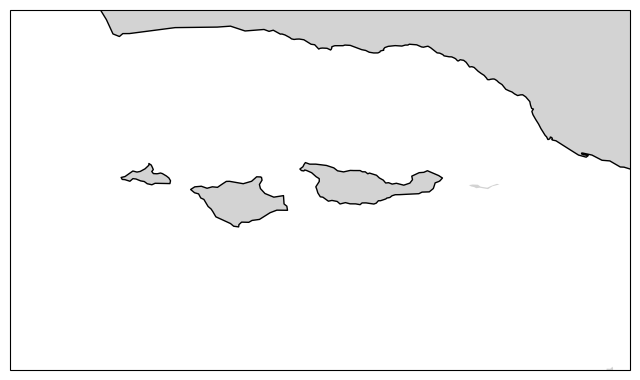

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import numpy as np

# static map
lon_min, lon_max = kelp_bbox["lon_min"], kelp_bbox["lon_max"]
lat_min, lat_max = kelp_bbox["lat_min"], kelp_bbox["lat_max"]
pad = 0.02

fig, ax = plt.subplots(
    figsize=(8, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

ax.set_extent(
    [lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad],
    crs=ccrs.PlateCarree()
)

ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)

title = ax.set_title("", fontsize=14, weight="bold")

### Create a frame for each date

In [7]:
# empty scatter layers
scat1 = ax.scatter([], [], s=6, c="royalblue", label="Type I", alpha=0.7)
scat2 = ax.scatter([], [], s=6, c="seagreen", label="Type II", alpha=0.7)
scat3 = ax.scatter([], [], s=6, c="saddlebrown", label="Type III", alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right", frameon=True)

# create a frame per date
def update(i):
    frame = frames[i]

    lon = frame["lon"]
    lat = frame["lat"]
    t1 = frame["t1"]
    t2 = frame["t2"]
    t3 = frame["t3"]

    scat1.set_offsets(np.c_[lon[t1], lat[t1]])
    scat2.set_offsets(np.c_[lon[t2], lat[t2]])
    scat3.set_offsets(np.c_[lon[t3], lat[t3]])

    title.set_text(f"QWIP Color Types — {frame['date'].date()}")

    return scat1, scat2, scat3, title


### Animate those all together to form a gif!

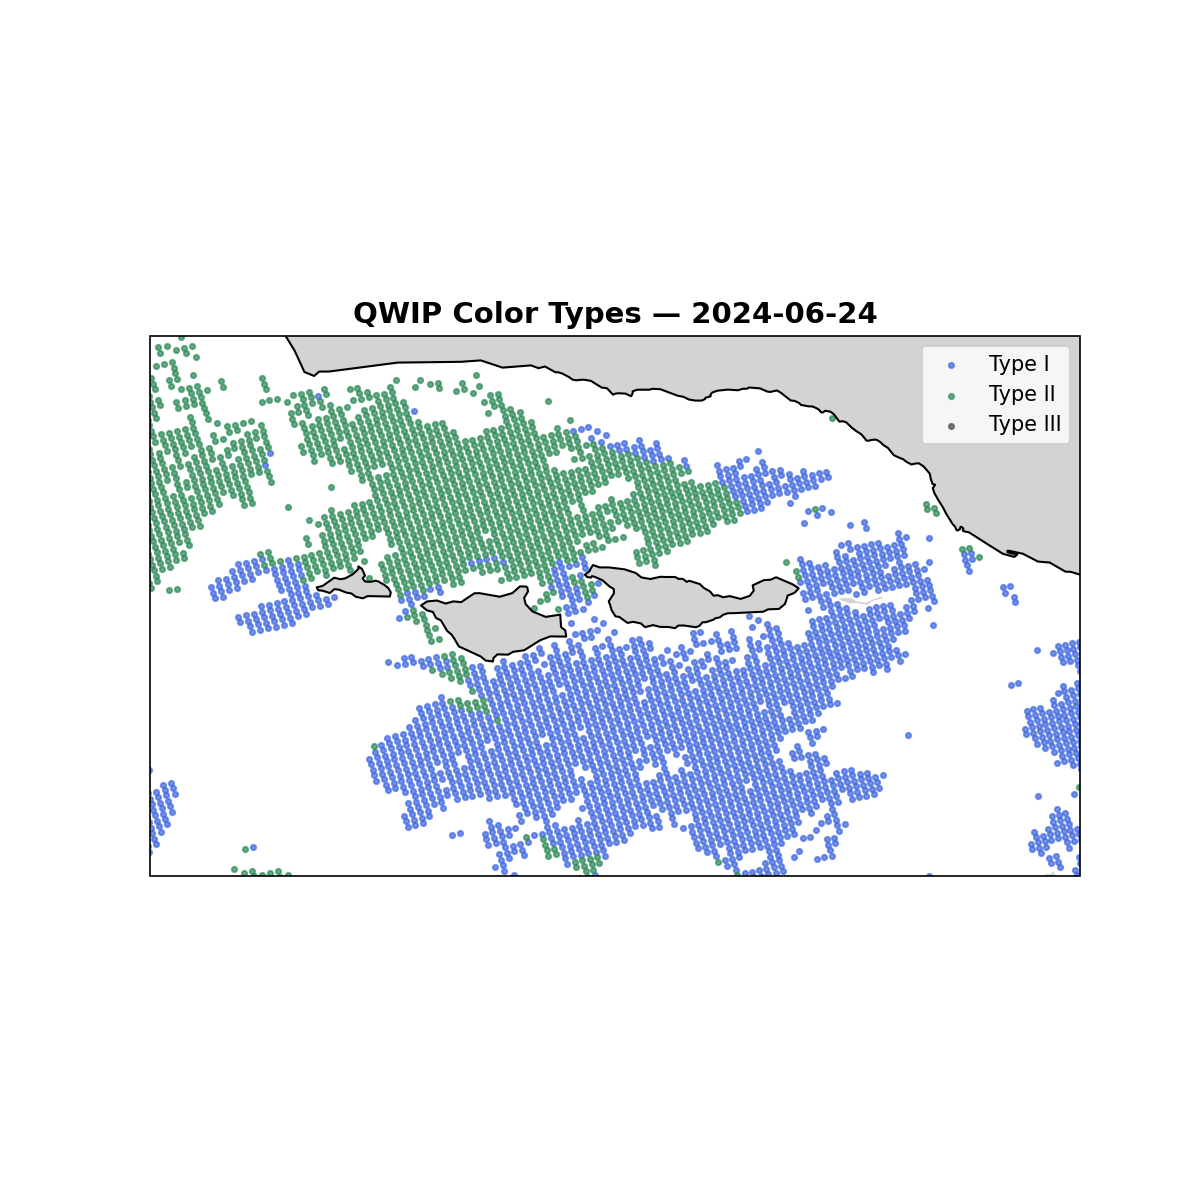

In [8]:
ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(frames),
    interval=900,   # ms between frames
    blit=False
)

ani.save(
    "kelp_qwip_daily.gif",
    writer="pillow",
    dpi=150
)

from IPython.display import Image
Image(filename="kelp_qwip_daily.gif")


## We can plot change in color over time 
Adding coastal upwelling index (CUTI) to see how that may coincide with changes in kelp forests

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# load in CUTI data
cuti = xr.open_dataset('/home/jovyan/2026-proj-kelp-west/data/CUTI_daily.nc')
cuti.head()

# select time slice
cuti_da = cuti.sel(
    latitude=34,
    time=slice("2024-06-24", "2024-06-27")
)

# create dataframe
cuti_da = cuti_da["CUTI"]

### Create plot

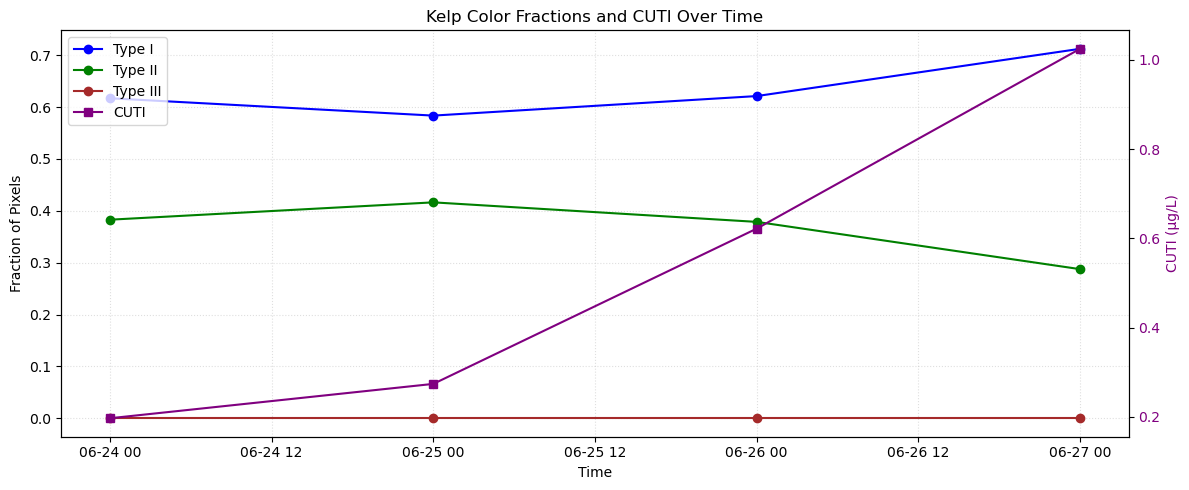

In [10]:
df = pd.DataFrame(records).set_index("date")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

# Colors for kelp types
custom_colors = {"Type I":"blue", "Type II":"green", "Type III":"brown"}

# Plot kelp color fractions on left y-axis
ax1.plot(df.index, df["type1_frac"], 'o-', label="Type I", color=custom_colors["Type I"])
ax1.plot(df.index, df["type2_frac"], 'o-', label="Type II", color=custom_colors["Type II"])
ax1.plot(df.index, df["type3_frac"], 'o-', label="Type III", color=custom_colors["Type III"])
ax1.set_xlabel("Time")
ax1.set_ylabel("Fraction of Pixels")
ax1.grid(True, linestyle=":", alpha=0.4)

# Create secondary y-axis for CUTI
ax2 = ax1.twinx()
ax2.plot(cuti_da["time"], cuti_da, 's-', label="CUTI", color="purple")
ax2.set_ylabel("CUTI (µg/L)", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Kelp Color Fractions and CUTI Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Is there a correlation between CUTI and Type II fraction?

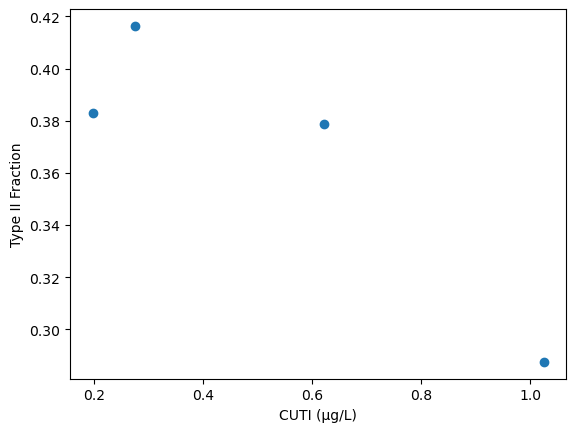

In [11]:
# select latitude 34
cuti_da = cuti.sel(
    latitude=34,
)["CUTI"]

df['cuti'] = cuti_da.sel(time=slice("2024-06-24", "2024-06-27")) # align same dates

df[['type1_frac','type2_frac','type3_frac','cuti']].corr()

plt.scatter(df['cuti'], df['type2_frac'])
plt.xlabel('CUTI (µg/L)')
plt.ylabel('Type II Fraction')
plt.show()

## Let's see CUTI over the year to see when would be a good time to look at the kelp forest

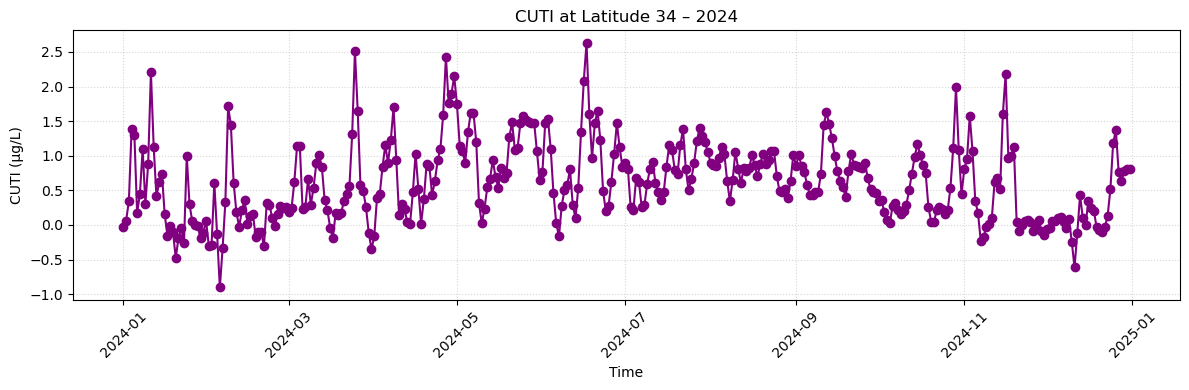

In [12]:
# restrict to all of 2024
cuti_da_year = cuti_da.sel(time=slice("2024-01-01", "2024-12-31"))

# Plot
plt.figure(figsize=(12, 4))
plt.plot(cuti_da_year["time"], cuti_da_year, '-o', color="purple")
plt.xlabel("Time")
plt.ylabel("CUTI (µg/L)")
plt.title("CUTI at Latitude 34 – 2024")
plt.grid(True, linestyle=":", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# dates from annie
<DatetimeArray>
['2024-06-24 00:00:00', '2024-06-25 00:00:00', '2024-06-26 00:00:00',
 '2024-06-27 00:00:00', '2024-07-01 00:00:00', '2024-07-02 00:00:00',
 '2024-07-03 00:00:00', '2024-07-05 00:00:00', '2024-07-08 00:00:00',
 '2024-07-09 00:00:00', '2024-07-11 00:00:00', '2024-07-23 00:00:00',
 '2024-07-24 00:00:00', '2024-07-25 00:00:00', '2024-07-29 00:00:00',
 '2024-07-30 00:00:00', '2024-07-31 00:00:00', '2024-08-01 00:00:00',
 '2024-08-02 00:00:00', '2024-08-07 00:00:00', '2024-08-08 00:00:00',
 '2024-08-09 00:00:00', '2024-08-13 00:00:00', '2024-08-16 00:00:00',
 '2024-08-20 00:00:00', '2024-08-21 00:00:00', '2024-08-22 00:00:00',
 '2024-08-23 00:00:00', '2024-08-26 00:00:00', '2024-08-27 00:00:00',
 '2024-08-28 00:00:00', '2024-08-29 00:00:00', '2024-09-03 00:00:00',
 '2024-09-23 00:00:00', '2024-10-01 00:00:00', '2024-10-09 00:00:00',
 '2024-10-21 00:00:00', '2024-10-22 00:00:00', '2024-11-01 00:00:00']

## Let's import the PISCO site coordinates

In [57]:
import pandas as pd

kelp_coords = [
    (34.01666667, -119.3616667),
    (34.017033, -119.361133),
    (34.007833, -119.394467),
    (34.015867, -119.371733),
    (34.0100609, -119.3877751),
    (34.02805, -119.690917),
    (34.0525, -119.55525),
    (34.40295, -119.864517),
    (34.404733, -119.876283),
    (34.42185, -119.9515),
    (34.423333, -119.951017),
    (34.424633, -119.955317),
    (34.46835, -120.125183),
    (34.017667, -119.363683),
    (34.016083, -119.421833),
    (34.053883, -119.9182),
    (33.946467, -119.823183),
    (33.94966667, -119.8275833),
    (33.948167, -119.82795),
    (34.010783, -119.3725),
    (34.0085, -119.388167),
    (34.01641667, -119.4320167),
    (34.016983, -119.432917),
    (34.017417, -119.438067),
    (34.05428333, -119.56685),
    (34.054283, -119.566867),
    (34.05275, -119.5713),
    (34.466283, -120.116967),
    (34.38945, -119.544767),
    (34.391733, -119.5577),
    (34.003083, -119.404167),
    (34.012783, -119.363133),
    (34.074483, -119.882133),
    (34.056583, -119.821167),
    (34.054383, -119.81935),
    (34.0141, -119.3590167),
    (34.0139, -119.3590167),
    (33.89753333, -120.10075),
    (33.897433, -120.100383),
    (33.895133, -120.104317),
    (33.9817, -119.6637),
    (34.051483, -119.909667),
    (34.03065, -119.69665),
    (34.002883, -119.4252),
    (34.003433, -119.418),
    (34.00775, -119.434383),
    (34.001583, -119.398067),
    (33.931667, -120.197417),
    (33.92303333, -120.1873667),
    (33.923833, -120.192),
    (33.894167, -120.124883),
    (34.0719, -119.85755),
    (33.98983333, -119.5630667),
    (33.9893, -119.564933),
    (34.04493333, -119.6014),
    (34.044933, -119.6014),
    (34.0434, -119.535733),
    (33.988533, -119.546983),
    (34.04415, -119.54245),
    (34.04265, -119.604),
    (33.983617, -119.6384),
    (33.98355, -119.620317),
    (34.052783, -120.337383),
    (33.89233333, -120.1195),
    (33.891567, -120.1192),
    (34.038367, -119.5253),
    (34.048467, -119.546367),
    (34.050983, -119.575883),
    (34.04225, -119.5316),
    (34.05223333, -119.5825333),
    (34.052167, -119.582117),
    (34.04798333, -119.5514),
    (34.047983, -119.5514)
]

# convert to df
kelp_points = pd.DataFrame(kelp_coords, columns=["lat", "lon"])

         lat         lon
0  34.016667 -119.361667
1  34.017033 -119.361133
2  34.007833 -119.394467
3  34.015867 -119.371733
4  34.010061 -119.387775


## Let's try to add a kelp index 
Aim: to separate kelp from other algae that may be giving a type II signal

In [18]:
def compute_kelp_index(ds):
    """
    Compute NDVI-like kelp index from PACE OCI Rrs
    """
    wl = ds["wavelength_3d"].values.astype(float)

    # Find nearest bands
    red_wl = wl[np.argmin(np.abs(wl - 665))]
    nir_wl = wl[np.argmin(np.abs(wl - 740))]

    R_red = ds["Rrs"].sel(wavelength_3d=red_wl)
    R_nir = ds["Rrs"].sel(wavelength_3d=nir_wl)

    kelp_index = (R_nir - R_red) / (R_nir + R_red)

    return kelp_index, red_wl, nir_wl


New QWIP including the kelp index

In [20]:
def run_qwip_chunked(ds, tol=0.2, lines_per_chunk=32):
    """
    Run QWIP per chunk, return only good (±tol) Type I/II/III pixels + coords.
    """

    # --- wavelengths ---
    wavelengths = ds["wavelength_3d"].values.astype(float)
    vis = (wavelengths >= 400) & (wavelengths <= 720)
    wavelengths_vis = wavelengths[vis]

    n_lines = ds.sizes["number_of_lines"]

    # --- output containers ---
    all_lat, all_lon = [], []
    all_ind_400A, all_ind_500A, all_ind_600A = [], [], []
    all_kelp_idx = []

    # --- chunk loop ---
    for i0 in range(0, n_lines, lines_per_chunk):
        i1 = min(i0 + lines_per_chunk, n_lines)

        Rrs_chunk = (
            ds["Rrs"]
            .isel(number_of_lines=slice(i0, i1))
            .sel(wavelength_3d=wavelengths_vis)
        )

        lat_chunk = ds["latitude"].isel(number_of_lines=slice(i0, i1))
        lon_chunk = ds["longitude"].isel(number_of_lines=slice(i0, i1))

        # reshape → (n_samples, n_wl)
        Rrs_np = (
            Rrs_chunk
            .transpose("number_of_lines", "pixels_per_line", "wavelength_3d")
            .values
        )
        rrs = Rrs_np.reshape(-1, Rrs_np.shape[-1])

        # mask invalid
        rrs[rrs <= 0] = np.nan
        good = np.all(np.isfinite(rrs), axis=1)
        if not np.any(good):
            continue

        rrs = rrs[good]

        # QWIP
        avw = calc_avw(wavelengths_vis, rrs)
        results = process_qwip_data(wavelengths_vis, rrs, avw)

        # strict QWIP filter
        good_qwip = np.abs(results["QWIP_Score"]) <= tol
        if not np.any(good_qwip):
            continue

        # kelp index
        kelp_idx_chunk, _, _ = compute_kelp_index(ds)
        kelp_idx_chunk = kelp_idx_chunk.isel(number_of_lines=slice(i0, i1))


        # append
        all_ind_400A.append(results["ind_400A"][good_qwip])
        all_ind_500A.append(results["ind_500A"][good_qwip])
        all_ind_600A.append(results["ind_600A"][good_qwip])

        lat_flat = lat_chunk.values.reshape(-1)[good][good_qwip]
        lon_flat = lon_chunk.values.reshape(-1)[good][good_qwip]
        kelp_idx_flat = kelp_idx_chunk.values.reshape(-1)
        kelp_idx_flat = kelp_idx_flat[good][good_qwip]

        all_kelp_idx.append(kelp_idx_flat)
        all_lat.append(lat_flat)
        all_lon.append(lon_flat)

    # concatenate once
    return (
        np.concatenate(all_lat),
        np.concatenate(all_lon),
        np.concatenate(all_ind_400A),
        np.concatenate(all_ind_500A),
        np.concatenate(all_ind_600A),
        np.concatenate(all_kelp_idx),
    )
    print("Chunk lines", i0, "-", i1, "good pixels:", np.sum(good), 
          "good QWIP:", np.sum(good_qwip))

New summary stats

In [32]:
MIN_PIXELS = 300000

def kelp_color_stats(lat, lon, t1, t2, t3, kelp_idx, roi):
    in_roi = (
        (lon >= roi["lon_min"]) & (lon <= roi["lon_max"]) &
        (lat >= roi["lat_min"]) & (lat <= roi["lat_max"])
    )

    kelp_like = kelp_idx > 0.05

    t2_kelp = t2 & kelp_like & in_roi

    n_kelp = int(np.count_nonzero(t2_kelp))
    n_roi = int(np.count_nonzero(in_roi))

   # n = int(t1.sum() + t2.sum() + t3.sum())  # <- cast to int
    
   # if n < MIN_PIXELS:
       # return None

    return {
        "kelp_frac": n_kelp / n_roi,
        "n_kelp_pixels": n_kelp,
    }


In [43]:
import pandas as pd 

# login to earthaccess
auth = earthaccess.login(persist=True)

dates = pd.date_range("2024-06-24", "2024-06-27", freq="D")

records = []      # time series stats
frames = []       # per-day spatial frames

for date in dates:
    print(f"Processing {date.date()}")

    results = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP",
        temporal=(str(date.date()), str(date.date())),
        bounding_box=(
            kelp_bbox["lon_min"],
            kelp_bbox["lat_min"],
            kelp_bbox["lon_max"],
            kelp_bbox["lat_max"],
        ),
    )

    if not results:
        print(f"No data found for {date.date()}")
        continue

    files = earthaccess.open(results)
    dtree = xr.open_datatree(files[0], decode_timedelta=False)
    ds = xr.merge(dtree.to_dict().values()).unify_chunks()

    # QWIP spatial output
    lat, lon, t1, t2, t3, kelp_idx = run_qwip_chunked(ds, tol=0.2)

    if len(lat) == 0:
        print(f"No valid QWIP pixels for {date.date()}")
        continue

    # Store frame for animation
    frames.append({
        "date": date,
        "lat": lat,
        "lon": lon,
        "t1": t1,
        "t2": t2,
        "t3": t3,
        "kelp_idx": kelp_idx,
    })

    # per day stats
    stats = kelp_color_stats(lat, lon, t1, t2, t3, kelp_idx, kelp_bbox)
    if stats:
        stats["date"] = date
        records.append(stats)
    if stats is None:
        print(f"Skipping {date.date()}: not enough valid QWIP pixels")
        continue

# Build DataFrame 
df = pd.DataFrame(records).set_index("date")
print(df)

Processing 2024-06-24


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2024-06-25


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Processing 2024-06-26


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Processing 2024-06-27


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

            kelp_frac  n_kelp_pixels
date                                
2024-06-24   0.002017              8
2024-06-25   0.000000              0
2024-06-26   0.001284              1
2024-06-27   0.000166              1


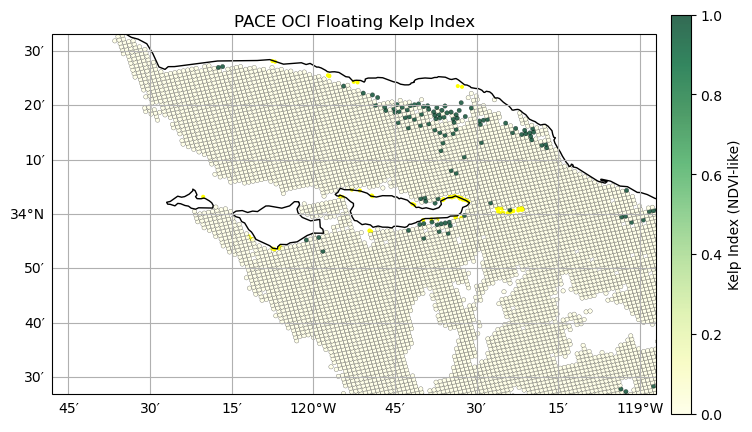

In [62]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# Create figure with map projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# add kelp forest stars outlines
for _, row in kelp_points.iterrows():
    circle = plt.Circle(
        (row["lon"], row["lat"]),
        0.003,            # radius in degrees (~300m, adjust as needed)
        color='yellow',
        fill=False,
        linewidth=1.5
    )
    plt.gca().add_patch(circle)

# Plot the kelp index
sc = ax.scatter(
    lon, lat, c=kelp_idx > 0, s=10, cmap="YlGn",
    alpha=0.8, edgecolors="k", linewidth=0.2,
    transform=ccrs.PlateCarree()
)
# Add coastlines and borders
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# Set extent to zoom in on your region
ax.set_extent([lon_min-0.05, lon_max+0.05, lat_min-0.05, lat_max+0.05], crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)
cbar.set_label("Kelp Index (NDVI-like)")

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False

# Title
ax.set_title("PACE OCI Floating Kelp Index")

plt.tight_layout()
plt.show()


## Try animating map

2024-06-24 | kelp pixels: 1043
2024-06-24 | kelp pixels: 1043
2024-06-25 | kelp pixels: 1455
2024-06-26 | kelp pixels: 3326
2024-06-27 | kelp pixels: 1837


2024-06-24 | kelp pixels: 1043


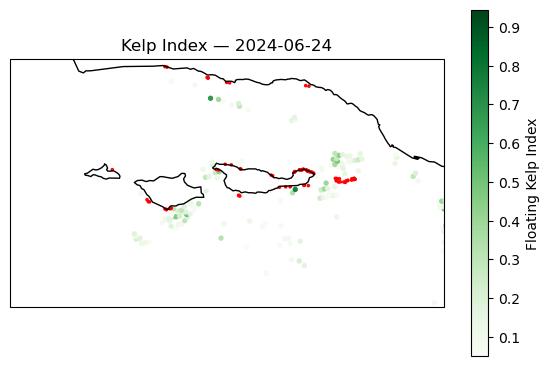

In [69]:
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

KELP_THRESH = 0.05  # deliberately low for now

fig, ax = plt.subplots(
    figsize=(7,6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax.set_extent([
    kelp_bbox["lon_min"],
    kelp_bbox["lon_max"],
    kelp_bbox["lat_min"],
    kelp_bbox["lat_max"]
])

ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

sc = ax.scatter(
    [0], [0],           
    s=8,
    c=[KELP_THRESH],    
    cmap="Greens",
    vmin=KELP_THRESH,
    vmax=max(frame["kelp_idx"].max() for frame in frames),  # max across all frames
    transform=ccrs.PlateCarree()
)

# add kelp forests
kelp_circles = []
for _, row in kelp_points.iterrows():
    circle = Circle((row["lon"], row["lat"]), 0.003, color='red', fill=False, linewidth=1.5)
    ax.add_patch(circle)
    kelp_circles.append(circle)

cbar = plt.colorbar(sc, ax=ax, shrink=0.75)
cbar.set_label("Floating Kelp Index")

title = ax.set_title("")

def update(i):
    frame = frames[i]

    kelp = frame["kelp_idx"]
    lat = frame["lat"]
    lon = frame["lon"]

    mask = kelp > KELP_THRESH

    print(f"{frame['date'].date()} | kelp pixels:", np.sum(mask))

    if np.sum(mask) == 0:
        sc.set_offsets(np.empty((0, 2)))
        sc.set_array(np.array([]))
    else:
        offsets = np.column_stack((lon[mask], lat[mask]))
        sc.set_offsets(offsets)
        sc.set_array(kelp[mask])

    title.set_text(f"Kelp Index — {frame['date'].date()}")
    return sc,

anim = FuncAnimation(
    fig,
    update,
    frames=len(frames),
    interval=800,
    blit=False
)

from IPython.display import HTML
HTML(anim.to_jshtml())

## Now, look at kelp index over time
We are going to try to filter to only count points within a certain distance from our PISCO sites

In [70]:
import numpy as np

def pixels_within_radius(lat_pixels, lon_pixels, kelp_points, radius_deg=0.01):
    """
    lat_pixels, lon_pixels: 1D arrays of pixel coordinates
    kelp_points: DataFrame with 'lat' and 'lon' columns
    radius_deg: radius in degrees (~0.01 ~ 1 km, adjust as needed)
    Returns a boolean mask of pixels within radius of any kelp point
    """
    mask = np.zeros_like(lat_pixels, dtype=bool)
    for _, row in kelp_points.iterrows():
        dlat = lat_pixels - row['lat']
        dlon = lon_pixels - row['lon']
        distance = np.sqrt(dlat**2 + dlon**2)  # degrees
        mask |= (distance <= radius_deg)
    return mask


In [74]:
radius_deg = 0.01  # ~1 km
records_near_kelp = []

for frame in frames:
    mask = pixels_within_radius(frame["lat"], frame["lon"], kelp_points, radius_deg)
    
    if np.sum(mask) == 0:
        continue
    
    t1 = frame["t1"][mask]
    t2 = frame["t2"][mask]
    t3 = frame["t3"][mask]
    kelp_vals = frame["kelp_idx"][mask]
    
    n = t1.sum() + t2.sum() + t3.sum()
    if n == 0:
        continue
    
    records_near_kelp.append({
        "date": frame["date"],
        "type1_frac": t1.sum()/n,
        "type2_frac": t2.sum()/n,
        "type3_frac": t3.sum()/n,
        "mean_kelp_idx": kelp_vals.mean(),
        "n_pixels": n
    })

df_near_kelp = pd.DataFrame(records_near_kelp).set_index("date")

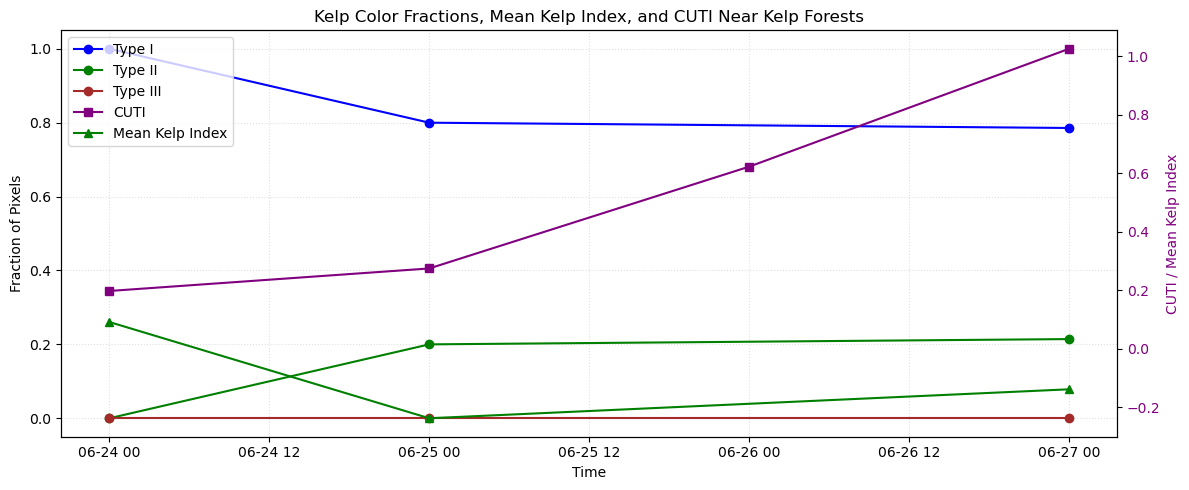

In [75]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Colors for kelp types
custom_colors = {"Type I":"blue", "Type II":"green", "Type III":"brown"}

# Plot kelp color fractions on left y-axis
ax1.plot(df_near_kelp.index, df_near_kelp["type1_frac"], 'o-', label="Type I", color=custom_colors["Type I"])
ax1.plot(df_near_kelp.index, df_near_kelp["type2_frac"], 'o-', label="Type II", color=custom_colors["Type II"])
ax1.plot(df_near_kelp.index, df_near_kelp["type3_frac"], 'o-', label="Type III", color=custom_colors["Type III"])
ax1.set_xlabel("Time")
ax1.set_ylabel("Fraction of Pixels")
ax1.grid(True, linestyle=":", alpha=0.4)

# Secondary y-axis for CUTI and Kelp Index
ax2 = ax1.twinx()
ax2.plot(cuti_da["time"], cuti_da, 's-', label="CUTI", color="purple")
ax2.plot(df_near_kelp.index, df_near_kelp["mean_kelp_idx"], '^-', label="Mean Kelp Index", color="green")
ax2.set_ylabel("CUTI / Mean Kelp Index", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Kelp Color Fractions, Mean Kelp Index, and CUTI Near Kelp Forests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
